In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
from torch import nn

In [3]:
# Import cifar-10 dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

data_path = './data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified


In [4]:
train_imgs = torch.stack([img for img, _ in cifar10], dim=3)
view = train_imgs.view(3, -1)#.to(device=device)

mean = train_imgs.view(3, -1).mean(dim=1)
std = train_imgs.view(3, -1).std(dim=1)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(cifar10_train, batch_size=64, shuffle=True)

cifar10_val = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
val_loader = DataLoader(cifar10_val, batch_size=64, shuffle=False)

cifar_val_x = torch.empty((3, 32, 32, len(cifar10_val)), device=device)
cifar_val_y = torch.empty(len(cifar10_val), dtype=torch.long, device=device)

for epoch, (img, label) in enumerate(cifar10_val):
    cifar_val_x[:, :, :, epoch] = img
    cifar_val_y[epoch] = label

cifar_val_x = cifar_val_x.view(3, -1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

class Classifier(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print('Comparing results:')
        comparisons = {
            'accuracy': 100*(results1['accuracy'] - results2['accuracy'])/results1['accuracy'],
            'precision': 100*(results1['precision'] - results2['precision'])/results1['precision'],
            'recall': 100*(results1['recall'] - results2['recall'])/results1['recall'],
            'f1': 100*(results1['f1'] - results2['f1'])/results1['f1']
        }
        for key, value in comparisons.items():
            print(f'{key}: {value} %')
        
    def __init__(self):
        super().__init__()
    
    def get_results(self, Y_val=None, Y_pred=None):
        if Y_val is None:
            Y_val = self.last_val
        if Y_pred is None:
            Y_pred = self.last_pred
            
        if isinstance(Y_val, torch.Tensor):
            Y_val = Y_val.cpu().detach().numpy()
        if isinstance(Y_pred, torch.Tensor):
            Y_pred = Y_pred.cpu().detach().numpy()
        results = {
            'accuracy': accuracy_score(Y_val, Y_pred),
            'precision': precision_score(Y_val, Y_pred, average='weighted'),
            'recall': recall_score(Y_val, Y_pred, average='weighted'),
            'f1': f1_score(Y_val, Y_pred, average='weighted'),
            'confusion_matrix': confusion_matrix(Y_val, Y_pred),
            'classification_report': classification_report(Y_val, Y_pred)
        }
        self.last_results = results
        return results
    def print_results(self, results=None):
        if results is None:
            try: 
                results = self.last_results
            except:
                results = self.get_results()
        for key, value in results.items():
            if key in ['confusion_matrix', 'classification_report']:
                print(f'{key.capitalize()}:\n{value}')
            else:
                print(f'{key.capitalize()}: {value}')
    def plot_training(self, title: str):
        loss_hist = self.train_loss_hist.cpu().detach().numpy()
        accuracy_hist = self.train_accuracy_hist.cpu().detach().numpy()
        validation_accuracy_hist = self.validation_accuracy_hist.cpu().detach().numpy()
        
        fig, ax = plt.subplots(1,2, sharex=True)
        fig.suptitle(title)
        ax[0].set_title('Training Loss')
        ax[0].set_xlabel('Epoch')
        ax[0].set_ylabel('Loss')
        ax[0].plot(loss_hist, label='Training Loss')
        
        
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('Epoch')
        ax[1].set_ylabel('Accuracy')
        ax[1].plot(accuracy_hist, label='Training Accuracy')
        ax[1].plot(validation_accuracy_hist, label='Validation Accuracy')
        
        plt.legend()
        plt.show()
    def plot_confusion_matrix(self, title):
        if self.last_results is None:
            self.get_results()
        cm = self.last_results['confusion_matrix']
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        disp.ax_.set_title(title)
        
        
        
        
        
                
    
import time
from math import floor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class PerceptronClassifier(Classifier):
    def __init__(self, input_dim=0, output_dim = 0, activation=nn.ReLU, hidden_layers = [64, 32, 16], pass_through=False):
        super().__init__()
        self.stack_list = [nn.Flatten(), nn.Linear(input_dim, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])  
        
        self.stack_list.append(nn.Linear(hidden_layers[-1], output_dim))
        self.stack = nn.Sequential(*self.stack_list)
    def forward(self, x):
        return self.stack(x)
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(dim=1)
    def train_model(
        self,
        epochs: int,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        alpha: float,
        loss_fn: nn.Module = nn.CrossEntropyLoss(),
        optimizer: nn.Module = torch.optim.SGD,
        print_epoch: int = 10,
        **optimizer_kwargs,
    ):
        self.train_loss_hist = torch.zeros(epochs).to(device)
        self.train_accuracy_hist = torch.zeros(epochs).to(device)
        self.validation_accuracy_hist = torch.zeros(epochs).to(device)
        
        
        optimizer = optimizer(self.parameters(), lr=alpha, **optimizer_kwargs)
        training_time = 0
        for epoch in range(epochs):
            self.train()
            
            start_time = time.time()
            train_loss = 0
            train_correct = torch.zeros(1).to(device)
            
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                optimizer.zero_grad()
                Y_pred = self.forward(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                train_correct += (Y_pred.argmax(dim=1) == Y_batch).sum()
            training_time += time.time() - start_time
            
            self.train_accuracy_hist[epoch] = train_correct/len(train_loader.dataset)
            self.train_loss_hist[epoch] = train_loss/len(train_loader)
            
            val_correct = torch.zeros(1).to(device)
            self.eval()
            with torch.no_grad():
                Y_pred_eval = torch.zeros(len(val_loader.dataset)).to(device)
                
                idx = 0
                for X_val_batch, Y_val_batch in val_loader:
                    X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)
                    batch_size = X_val_batch.size(0)
                    Y_pred = self.predict(X_val_batch)
                    Y_pred_eval[idx:idx + batch_size] = Y_pred
                    val_correct += (Y_pred == Y_val_batch).sum()
                    idx += batch_size
                    
                self.validation_accuracy_hist[epoch] = val_correct/len(val_loader.dataset)
            epoch_time = time.time() - start_time
            
                    
                
        
            if epoch % print_epoch == 0:
                rem_time = (epochs - epoch)*epoch_time / 60
                rem_time_str = f'{floor(rem_time):02}:{floor((rem_time - floor(rem_time))*60):02}'
                print(f'Epoch {epoch}: Training Loss: {(train_loss/len(train_loader))}, Training Accuracy: {(train_correct/len(train_loader.dataset)).item()}, Validation Accuracy: {(val_correct/len(val_loader.dataset)).item()}, Estimated Time Remaining: {rem_time_str}')
        self.last_pred = torch.tensor(Y_pred_eval)
        self.last_val = torch.tensor(val_loader.dataset.targets)
        print(f'\nTraining Time: {training_time} seconds\n')

            
            


Using device: cuda


In [6]:

retrain = False

if retrain:
    perceptron = PerceptronClassifier(input_dim=3*32*32, hidden_layers=[64, 32, 16], output_dim=10).to(device=device)
    perceptron.train_model(
        epochs=20,
        train_loader=train_loader,
        val_loader=val_loader,
        alpha=0.01,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        print_epoch=1.0,
        weight_decay = 0.001
    )
    pickle = torch.save(perceptron, 'models/perceptron.pt')
else:
    perceptron = torch.load('models/perceptron.pt')



/tmp/ipykernel_13927/3657261.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  perceptron = torch.load('models/perceptron.pt')


Accuracy: 0.4933
Precision: 0.4982036274497342
Recall: 0.4933
F1: 0.48210309623743286
Confusion_matrix:
[[576  30  31  12  26  11  44  31 178  61]
 [ 28 571   6  19   5  10  62  18  82 199]
 [102  11 272  53 106  69 253  82  32  20]
 [ 55   7  60 242  39 170 289  66  25  47]
 [ 49  13  90  34 300  42 322 104  27  19]
 [ 37   8  59 159  62 330 182 103  37  23]
 [ 17  15  41  43  52  26 743  23  17  23]
 [ 29  16  24  44  65  69  84 595  20  54]
 [ 77  57  11  12  12  25  32  13 705  56]
 [ 42 124   2  24  11  14  47  52  85 599]]
Classification_report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      1000
           1       0.67      0.57      0.62      1000
           2       0.46      0.27      0.34      1000
           3       0.38      0.24      0.29      1000
           4       0.44      0.30      0.36      1000
           5       0.43      0.33      0.37      1000
           6       0.36      0.74      0.49      1000
         

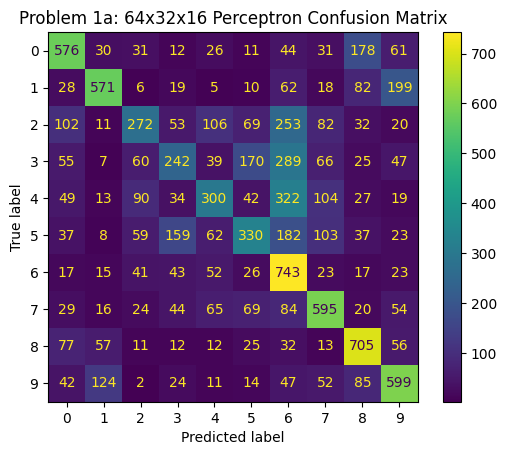

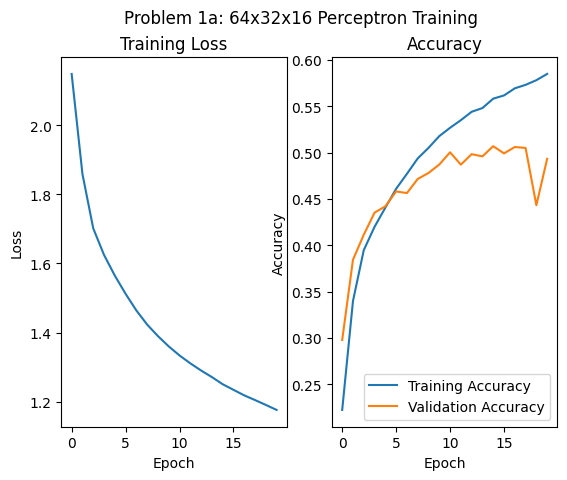

In [7]:
perceptron.print_results()
perceptron.plot_confusion_matrix('Problem 1a: 64x32x16 Perceptron Confusion Matrix')

perceptron.plot_training('Problem 1a: 64x32x16 Perceptron Training')

/tmp/ipykernel_13927/1540653026.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  complex_perceptron = torch.load('models/complex_perceptron.pt')


Accuracy: 0.5064
Precision: 0.5156006058151215
Recall: 0.5064
F1: 0.5005500099309592
Confusion_matrix:
[[607  29  79  34  28   3  24  24  99  73]
 [ 38 496   3  29   9   4  26  17  53 325]
 [ 76  11 308 140 153  72 146  57  11  26]
 [ 33   8  68 430  35 105 180  64  25  52]
 [ 69   4 123  81 389  24 176  92  17  25]
 [ 17   2  88 376  46 234 108  79  21  29]
 [  7  10  31  96  84  23 699  14  11  25]
 [ 36   2  28 101  89  67  15 583   7  72]
 [138  50   8  35  16   7  10   7 621 108]
 [ 53  88   5  43   8  10  21  43  32 697]]
Classification_report:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1000
           1       0.71      0.50      0.58      1000
           2       0.42      0.31      0.35      1000
           3       0.32      0.43      0.36      1000
           4       0.45      0.39      0.42      1000
           5       0.43      0.23      0.30      1000
           6       0.50      0.70      0.58      1000
          

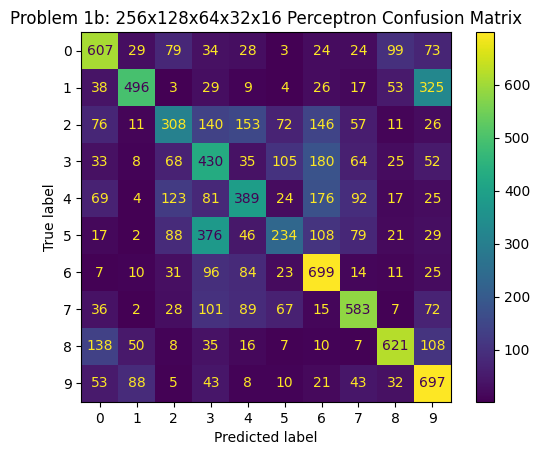

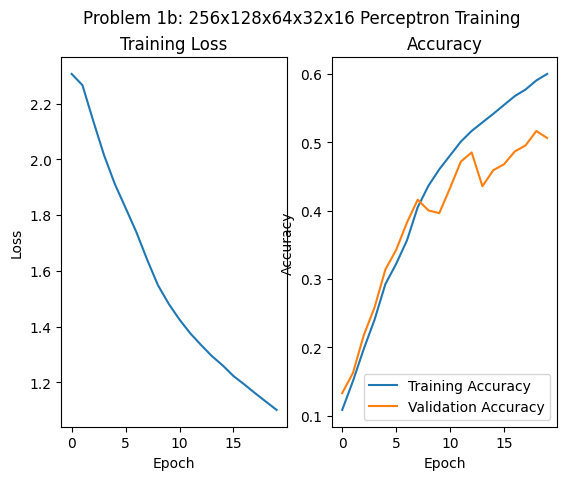

Comparing results:
accuracy: 2.5868878357029907 %
precision: 3.3741190699115093 %
recall: 2.5868878357029907 %
f1: 3.6853288038233654 %


In [8]:
retrain_complex = False

if retrain_complex:
    complex_perceptron = PerceptronClassifier(input_dim=3*32*32, hidden_layers=[256, 128, 64, 32, 16], output_dim=10).to(device=device)
    complex_perceptron.train_model(
        epochs=20,
        train_loader=train_loader,
        val_loader=val_loader,
        alpha=0.01,
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=torch.optim.SGD,
        print_epoch=1.0,
        weight_decay = 0.001
    ).to(device=device)
    torch.save(complex_perceptron, 'models/complex_perceptron.pt')
    
else:
    complex_perceptron = torch.load('models/complex_perceptron.pt')

complex_perceptron.print_results()
complex_perceptron.plot_confusion_matrix('Problem 1b: 256x128x64x32x16 Perceptron Confusion Matrix')
complex_perceptron.plot_training('Problem 1b: 256x128x64x32x16 Perceptron Training')
Classifier.compare_results(complex_perceptron.get_results(), perceptron.get_results())


Accuracy: 0.5064
Precision: 0.5156006058151215
Recall: 0.5064
F1: 0.5005500099309592
Confusion_matrix:
[[607  29  79  34  28   3  24  24  99  73]
 [ 38 496   3  29   9   4  26  17  53 325]
 [ 76  11 308 140 153  72 146  57  11  26]
 [ 33   8  68 430  35 105 180  64  25  52]
 [ 69   4 123  81 389  24 176  92  17  25]
 [ 17   2  88 376  46 234 108  79  21  29]
 [  7  10  31  96  84  23 699  14  11  25]
 [ 36   2  28 101  89  67  15 583   7  72]
 [138  50   8  35  16   7  10   7 621 108]
 [ 53  88   5  43   8  10  21  43  32 697]]
Classification_report:
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      1000
           1       0.71      0.50      0.58      1000
           2       0.42      0.31      0.35      1000
           3       0.32      0.43      0.36      1000
           4       0.45      0.39      0.42      1000
           5       0.43      0.23      0.30      1000
           6       0.50      0.70      0.58      1000
          

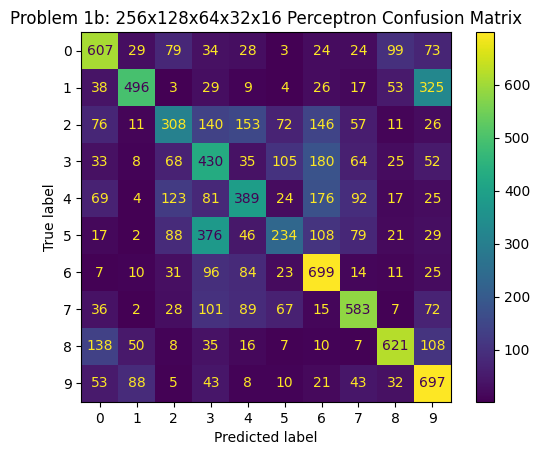

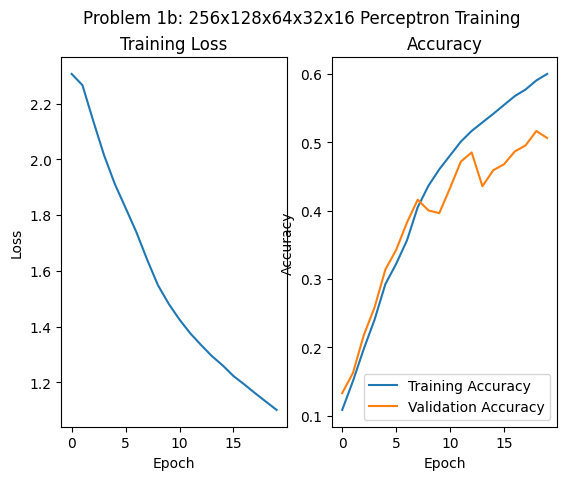

Comparing results:
accuracy: 2.5868878357029907 %
precision: 3.3741190699115093 %
recall: 2.5868878357029907 %
f1: 3.6853288038233654 %


In [9]:
complex_perceptron.print_results()
complex_perceptron.plot_confusion_matrix('Problem 1b: 256x128x64x32x16 Perceptron Confusion Matrix')
complex_perceptron.plot_training('Problem 1b: 256x128x64x32x16 Perceptron Training')
Classifier.compare_results(complex_perceptron.get_results(), perceptron.get_results())

In [56]:

from sklearn.preprocessing import OneHotEncoder
path = 'data/Housing.csv'
housing = pd.DataFrame(pd.read_csv(path))

varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

# Defining the map function
def binary_map(x):
    mapping = {'yes': 1, 'no': 0, 'unfurnished': 0, 'semi-furnished': 1, 'furnished': 2}
    return x.map(lambda val: mapping.get(val, val))

# Applying the function to the housing list

housing.head()

df_train, df_val = train_test_split(housing, train_size=0.8, test_size=0.2, random_state=100)

X_train_df: pd.DataFrame = df_train.apply(binary_map)
Y_train_df: pd.DataFrame = df_train.pop('price')
X_val_df: pd.DataFrame = df_val.apply(binary_map)
Y_val_df: pd.DataFrame = df_val.pop('price')


X_train_np = X_train_df.to_numpy()
X_val_np = X_val_df.to_numpy()

scaler = preprocessing.StandardScaler().fit(X_train_np)
X_train_np = scaler.transform(X_train_np)
X_val_np = scaler.transform(X_val_np)

X_train_housing = torch.tensor(X_train_np, device=device).float()
Y_train_housing = torch.tensor(Y_train_df.to_numpy(), device=device).float()

X_val_housing = torch.tensor(X_val_np, device=device).float()
Y_val_housing = torch.tensor(Y_val_df.to_numpy(), device=device).float()





In [57]:
categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder(sparse_output=False, handle_unknown='error')

one_hot_train_cat = encoder.fit_transform(df_train[categorical_columns])
one_hot_val_cat = encoder.transform(df_val[categorical_columns])

df_train_drop = df_train.drop(categorical_columns, axis=1)
df_val_drop = df_val.drop(categorical_columns, axis=1)

X_train_onehot = np.concatenate([df_train_drop.to_numpy(), one_hot_train_cat], axis=1)
X_val_onehot = np.concatenate([df_val_drop.to_numpy(), one_hot_val_cat], axis=1)

scaler = preprocessing.StandardScaler().fit(X_train_onehot)
X_train_onehot = scaler.transform(X_train_onehot)
X_val_onehot = scaler.transform(X_val_onehot)

X_train_housing_onehot = torch.tensor(X_train_onehot, device=device).float()
Y_train_housing_onehot = torch.tensor(Y_train_df.to_numpy(), device=device).float()

X_val_housing_onehot = torch.tensor(X_val_onehot, device=device).float()
Y_val_housing_onehot = torch.tensor(Y_val_df.to_numpy(), device=device).float()



In [79]:
import matplotlib.pyplot as plt

class Regressor(nn.Module):
    @classmethod
    def compare_results(cls, results1, results2):
        print(100 * (results1 - results2) / results1)
        
    def __init__(self, in_dim, out_dim, hidden_layers=[64,32], activation=nn.Tanh,):
        super().__init__()
        self.hidden_layers = hidden_layers
        self.activation = activation
        self.input_cols = []
        self.output_cols = []
        output_features = out_dim
        input_features = in_dim
        

        
        self.stack_list = [nn.Linear(input_features, hidden_layers[0]), activation()]
        for i in range(1, len(hidden_layers)):
            self.stack_list.extend([nn.Linear(hidden_layers[i-1], hidden_layers[i]), activation()])
        self.stack_list.extend([nn.Linear(hidden_layers[-1], output_features)])
        self.stack = nn.Sequential(*self.stack_list)
        
        
        
    def train_model(self, epochs, X_train, X_val, Y_train, Y_val, alpha=1e-2, loss_fn=nn.MSELoss(), optimizer=torch.optim.SGD, print_epoch=1):
        
        val_hist = np.zeros(epochs)
        train_hist = np.zeros(epochs)

        optimizer = optimizer(self.parameters(), lr=alpha, weight_decay=0.01)
        for epoch in range(epochs):
            
            self.train()
            optimizer.zero_grad()
            Y_pred = self.forward(X_train)
            loss = loss_fn(Y_pred.squeeze(), Y_train)
            loss.backward()
            optimizer.step()
            train_hist[epoch] = loss.item()
            
            self.eval()
            with torch.no_grad():
                Y_pred_val = self.forward(X_val)
                val_hist[epoch] = loss_fn(Y_pred_val, Y_val).item()
            
            if epoch % print_epoch == 0:
                print(f'Epoch {epoch}: Training Loss: {train_hist[epoch]:4e}, Validation Loss: {val_hist[epoch]:4e}')
            
            
        self.last_val = Y_val
        self.last_pred = self.forward(X_val)
        self.last_score = val_hist[-1]
        
        self.last_epochs = epochs
        self.last_val_hist = val_hist
        self.last_train_hist = train_hist
    
    def plot_loss(self, title):
        
        plt.plot(self.last_val_hist, label='Validation Loss')
        plt.plot(self.last_train_hist, label='Training Loss')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def forward(self, x):
        return self.stack(x)
    def get_results(self):
        if self.last_val is None:
            raise ValueError('No results to print')
        return self.last_score
    def print_results(self):
        if self.last_score is None:
            raise ValueError('No results to print')
        print(f'MSE: {self.last_score:.2E}')
        

In [80]:
retrain_2a = True
if retrain_2a:
    perceptronRegressor = Regressor(X_train_housing.size()[1], 1, hidden_layers=[1024, 1024, 1024], activation=nn.ReLU).to(device=device)
    perceptronRegressor.train_model(
        epochs = 500,
        X_train = X_train_housing,
        X_val = X_val_housing,
        Y_train = Y_train_housing,
        Y_val = Y_val_housing,
        alpha = 0.0005,
        loss_fn = nn.MSELoss(),
        optimizer = torch.optim.Adam,
        print_epoch=100
    )
    torch.save(perceptronRegressor, 'models/perceptronRegressor.pt')
else:
    perceptronRegressor = torch.load('models/perceptronRegressor.pt')

/home/jaskin/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Training Loss: 2.647760e+13, Validation Loss: 2.515876e+13
Epoch 100: Training Loss: 2.548886e+13, Validation Loss: 2.430394e+13
Epoch 200: Training Loss: 9.954131e+12, Validation Loss: 1.314801e+13
Epoch 300: Training Loss: 1.787518e+12, Validation Loss: 9.416552e+12
Epoch 400: Training Loss: 9.648445e+11, Validation Loss: 7.632929e+12


MSE: 7.17E+12


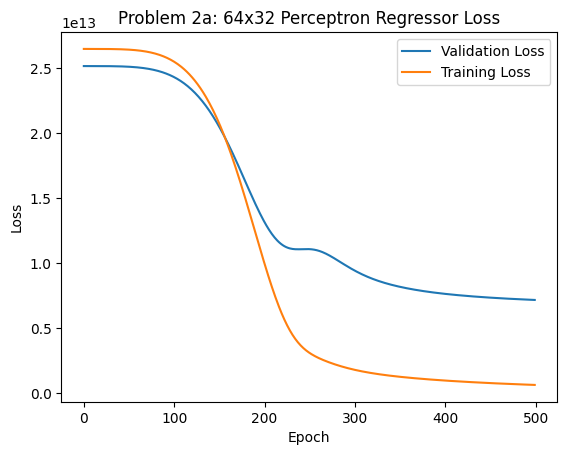

In [81]:
perceptronRegressor.print_results()
perceptronRegressor.plot_loss('Problem 2a: 1024x1024x1024 Perceptron Regressor Loss')

In [82]:
retrain_2b = True
if retrain_2b:
    perceptronRegressorOneHot = Regressor(X_train_housing_onehot.size()[1], 1, hidden_layers=[1024, 1024, 1024], activation=nn.ReLU).to(device=device)
    perceptronRegressorOneHot.train_model(
        epochs = 500,
        X_train = X_train_housing_onehot,
        X_val = X_val_housing_onehot,
        Y_train = Y_train_housing_onehot,
        Y_val = Y_val_housing_onehot,
        alpha = 0.0005,
        loss_fn = nn.MSELoss(),
        optimizer = torch.optim.Adam,
        print_epoch=100
    )
    torch.save(perceptronRegressorOneHot, 'models/perceptronRegressorOneHot.pt')
else:
    perceptronRegressorOneHot = torch.load('models/perceptronRegressorOneHot.pt')

Epoch 0: Training Loss: 2.647760e+13, Validation Loss: 2.515876e+13
Epoch 100: Training Loss: 2.540837e+13, Validation Loss: 2.419258e+13
Epoch 200: Training Loss: 8.537053e+12, Validation Loss: 1.139550e+13
Epoch 300: Training Loss: 1.473550e+12, Validation Loss: 7.808162e+12
Epoch 400: Training Loss: 1.133192e+12, Validation Loss: 6.812479e+12


MSE: 6.63E+12
7.513403323978993


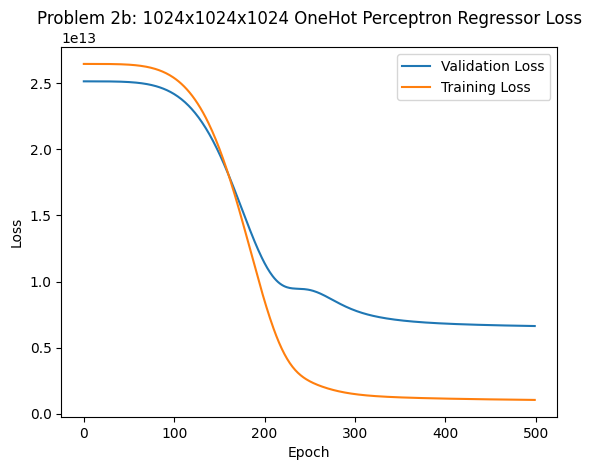

In [87]:
perceptronRegressorOneHot.print_results()
Regressor.compare_results(perceptronRegressor.get_results(), perceptronRegressorOneHot.get_results())
perceptronRegressorOneHot.plot_loss('Problem 2b: 1024x1024x1024 OneHot Perceptron Regressor Loss')

In [91]:
retrain_2c = True
if retrain_2c:
    perceptronRegressorOneHotComplex = Regressor(X_train_housing_onehot.size()[1], 1, hidden_layers=[2048, 1024, 1024, 1024, 512], activation=nn.ReLU).to(device=device)
    perceptronRegressorOneHotComplex.train_model(
        epochs = 500,
        X_train = X_train_housing_onehot,
        X_val = X_val_housing_onehot,
        Y_train = Y_train_housing_onehot,
        Y_val = Y_val_housing_onehot,
        alpha = 0.0001,
        loss_fn = nn.MSELoss(),
        optimizer = torch.optim.Adam,
        print_epoch=100
    )
    torch.save(perceptronRegressorOneHotComplex, 'models/perceptronRegressorOneHotComplex.pt')
else:
    perceptronRegressorOneHotComplex = torch.load('models/perceptronRegressorOneHotComplex.pt')

/home/jaskin/.local/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Training Loss: 2.647760e+13, Validation Loss: 2.515876e+13
Epoch 100: Training Loss: 2.555621e+13, Validation Loss: 2.427463e+13
Epoch 200: Training Loss: 1.893044e+12, Validation Loss: 6.567330e+12
Epoch 300: Training Loss: 1.228812e+12, Validation Loss: 6.381757e+12
Epoch 400: Training Loss: 1.101760e+12, Validation Loss: 6.440923e+12


MSE: 6.48E+12
9.646677180454596
2.306576231741368


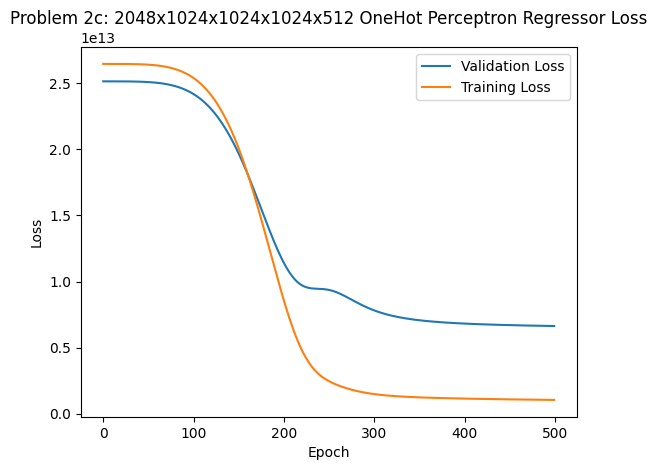

In [92]:
perceptronRegressorOneHotComplex.print_results()
Regressor.compare_results(perceptronRegressor.get_results(), perceptronRegressorOneHotComplex.get_results())
Regressor.compare_results(perceptronRegressorOneHot.get_results(), perceptronRegressorOneHotComplex.get_results())
perceptronRegressorOneHot.plot_loss('Problem 2c: 2048x1024x1024x1024x512 OneHot Perceptron Regressor Loss')